In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [3]:
font = {'weight' : 'bold',
        'size'   : 25}
plt.rc('font', **font)

In [4]:
from utils import process_from_census_data

### Import getting model

### Process data

In [5]:
file_loc = "data/new_data/final"
geo_lev = "POA"
type_check = "hh"

In [6]:
poa_data, poa_tot = process_from_census_data(geo_lev="POA", normalise=False, boxcox=False, keep_same=True, return_tot=True)
electric_vals = poa_data["Fuel type__Electric"]

In [7]:
electric_vals

3000    170.0
3002     32.0
3003     19.0
3004     82.0
3006     56.0
        ...  
3990      0.0
3991      0.0
3992      0.0
3995     14.0
3996     10.0
Name: Fuel type__Electric, Length: 691, dtype: float64

In [8]:
df_all = pd.read_csv(f"{file_loc}/syn_{type_check}_with_ev_score.csv", index_col=0)
df_all = df_all.rename(columns={"geog": geo_lev})
df_all = df_all.drop(columns=["serialno", "sample_geog", "cat_id"])
df_all

,dwelltype,owndwell,hhinc,totalvehs,hhsize,POA,EV_score_forest,EV_score_baye,EV_score_lr,EV_score_GraBoost
0,Flat or Apartment,Being Rented,1-149,0,1,3000,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08
1,Flat or Apartment,Being Rented,1-149,0,1,3000,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08
2,Flat or Apartment,Being Rented,1-149,0,1,3000,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08
3,Flat or Apartment,Being Rented,1-149,0,1,3000,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08
4,Flat or Apartment,Being Rented,1-149,0,1,3000,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08
...,...,...,...,...,...,...,...,...,...,...
2800602,Separate House,Being Purchased,1500-1749,4+,5,3996,8.177959e-03,-6.020214e-04,-2.319336e-03,4.172393e-03
2800603,Separate House,Something Else,650-799,1,4,3996,9.165376e-03,-1.795315e-03,-3.692627e-03,4.962682e-03
2800604,Separate House,Something Else,1000-1249,1,2,3996,3.999701e-03,-2.622213e-03,-1.800537e-03,1.041878e-03
2800605,Separate House,Being Purchased,4500-4999,3,3,3996,4.083682e-03,3.588240e-03,9.033203e-03,2.714568e-03


In [9]:
dict_num_ev =  {int(poa): int(val) for poa, val in zip(electric_vals.index, electric_vals)}
dict_num_ev

{3000: 170,
 3002: 32,
 3003: 19,
 3004: 82,
 3006: 56,
 3008: 65,
 3011: 33,
 3012: 17,
 3013: 23,
 3015: 12,
 3016: 19,
 3018: 37,
 3019: 3,
 3020: 33,
 3021: 25,
 3022: 0,
 3023: 38,
 3024: 11,
 3025: 13,
 3026: 490,
 3027: 13,
 3028: 3,
 3029: 74,
 3030: 86,
 3031: 11,
 3032: 39,
 3033: 12,
 3034: 5,
 3036: 3,
 3037: 24,
 3038: 28,
 3039: 21,
 3040: 40,
 3041: 22,
 3042: 21,
 3043: 105,
 3044: 38,
 3045: 0,
 3046: 31,
 3047: 10,
 3048: 17,
 3049: 3,
 3051: 43,
 3052: 4,
 3053: 13,
 3054: 14,
 3055: 9,
 3056: 35,
 3057: 17,
 3058: 82,
 3059: 12,
 3060: 20,
 3061: 24,
 3062: 0,
 3063: 0,
 3064: 94,
 3065: 26,
 3066: 32,
 3067: 14,
 3068: 24,
 3070: 41,
 3071: 16,
 3072: 45,
 3073: 42,
 3074: 27,
 3075: 13,
 3076: 75,
 3078: 21,
 3079: 31,
 3081: 10,
 3082: 12,
 3083: 26,
 3084: 34,
 3085: 14,
 3087: 7,
 3088: 30,
 3089: 12,
 3090: 3,
 3091: 9,
 3093: 11,
 3094: 11,
 3095: 39,
 3096: 0,
 3097: 3,
 3099: 7,
 3101: 87,
 3102: 18,
 3103: 39,
 3104: 46,
 3105: 9,
 3106: 38,
 3107: 4,
 310

In [10]:
# This is for the case of POA prefix in old file
# ls_zone_not_exist =  []
# for z in df_all[geo_lev].unique():
#     print(z)
#     check = z[3:]
#     if check not in electric_vals.index:
#         print(check)
#         dict_num_ev[f"POA{check}"] = 0 #special case

In [11]:
ls_cols_ev_pred = [x for x in df_all.columns if "EV_score" in x]

In [12]:
combine_fin_df = df_all[ls_cols_ev_pred+[geo_lev]]

## Assigning EV

In [13]:
combine_fin_df

,EV_score_forest,EV_score_baye,EV_score_lr,EV_score_GraBoost,POA
0,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000
1,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000
2,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000
3,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000
4,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000
...,...,...,...,...,...
2800602,8.177959e-03,-6.020214e-04,-2.319336e-03,4.172393e-03,3996
2800603,9.165376e-03,-1.795315e-03,-3.692627e-03,4.962682e-03,3996
2800604,3.999701e-03,-2.622213e-03,-1.800537e-03,1.041878e-03,3996
2800605,4.083682e-03,3.588240e-03,9.033203e-03,2.714568e-03,3996


In [14]:
# Make sense to have higher, some sa1 does not have households
print(len(dict_num_ev), len(df_all[geo_lev].unique()))

691 691


In [15]:
dict_thres = {}
ls_df = [] # Note these one will have diff index matching with original to combine later

for zone in df_all[geo_lev].unique():
    print(f"DOING {zone}")
    dict_thres[zone] = {}
    sub_df = combine_fin_df[combine_fin_df[geo_lev]==zone]
    num_ev = dict_num_ev[zone]
    ls_series = []
    for ev_pred in ls_cols_ev_pred:
        sort_df = sub_df.sort_values(ev_pred, ascending=False)
        n = len(sort_df)
        arr_val = ["NO" for _ in range(n)]
        arr_val[:num_ev] = ["YES" for _ in range(num_ev)]
        seri_ev_count = pd.Series(arr_val, index=sort_df.index, name=f"check_{ev_pred}")
        ls_series.append(seri_ev_count)

        # Find thres
        thres = sort_df[ev_pred].iat[num_ev-1]
        dict_thres[zone][ev_pred] = thres
    df_zone = pd.concat(ls_series, axis=1) # note the index
    ls_df.append(df_zone)

DOING 3000
DOING 3002
DOING 3003
DOING 3004
DOING 3006
DOING 3008
DOING 3011
DOING 3012
DOING 3013
DOING 3015
DOING 3016
DOING 3018
DOING 3019
DOING 3020
DOING 3021
DOING 3022
DOING 3023
DOING 3024
DOING 3025
DOING 3026
DOING 3027
DOING 3028
DOING 3029
DOING 3030
DOING 3031
DOING 3032
DOING 3033
DOING 3034
DOING 3036
DOING 3037
DOING 3038
DOING 3039
DOING 3040
DOING 3041
DOING 3042
DOING 3043
DOING 3044
DOING 3045
DOING 3046
DOING 3047
DOING 3048
DOING 3049
DOING 3051
DOING 3052
DOING 3053
DOING 3054
DOING 3055
DOING 3056
DOING 3057
DOING 3058
DOING 3059
DOING 3060
DOING 3061
DOING 3062
DOING 3063
DOING 3064
DOING 3065
DOING 3066
DOING 3067
DOING 3068
DOING 3070
DOING 3071
DOING 3072
DOING 3073
DOING 3074
DOING 3075
DOING 3076
DOING 3078
DOING 3079
DOING 3081
DOING 3082
DOING 3083
DOING 3084
DOING 3085
DOING 3087
DOING 3088
DOING 3089
DOING 3090
DOING 3091
DOING 3093
DOING 3094
DOING 3095
DOING 3096
DOING 3097
DOING 3099
DOING 3101
DOING 3102
DOING 3103
DOING 3104
DOING 3105
DOING 3106

In [16]:
ev_as_df = pd.concat(ls_df)
ev_as_df = ev_as_df.sort_index()
ev_as_df

,check_EV_score_forest,check_EV_score_baye,check_EV_score_lr,check_EV_score_GraBoost
0,NO,NO,NO,NO
1,NO,NO,NO,NO
2,NO,NO,NO,NO
3,NO,NO,NO,NO
4,NO,NO,NO,NO
...,...,...,...,...
2800602,NO,NO,NO,NO
2800603,NO,NO,NO,NO
2800604,NO,NO,NO,NO
2800605,NO,NO,NO,NO


In [17]:
final_df_all = pd.concat([combine_fin_df, ev_as_df], axis=1)
final_df_all

,EV_score_forest,EV_score_baye,EV_score_lr,EV_score_GraBoost,POA,check_EV_score_forest,check_EV_score_baye,check_EV_score_lr,check_EV_score_GraBoost
0,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000,NO,NO,NO,NO
1,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000,NO,NO,NO,NO
2,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000,NO,NO,NO,NO
3,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000,NO,NO,NO,NO
4,-1.000000e+08,-1.000000e+08,-1.000000e+08,-1.000000e+08,3000,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...
2800602,8.177959e-03,-6.020214e-04,-2.319336e-03,4.172393e-03,3996,NO,NO,NO,NO
2800603,9.165376e-03,-1.795315e-03,-3.692627e-03,4.962682e-03,3996,NO,NO,NO,NO
2800604,3.999701e-03,-2.622213e-03,-1.800537e-03,1.041878e-03,3996,NO,NO,NO,NO
2800605,4.083682e-03,3.588240e-03,9.033203e-03,2.714568e-03,3996,NO,NO,NO,NO


In [18]:
check_cols = [x for x in final_df_all.columns if "check_" in x]

for c in check_cols:
    print(final_df_all[c].value_counts())

check_EV_score_forest
NO     2792788
YES       7819
Name: count, dtype: int64
check_EV_score_baye
NO     2792788
YES       7819
Name: count, dtype: int64
check_EV_score_lr
NO     2792788
YES       7819
Name: count, dtype: int64
check_EV_score_GraBoost
NO     2792788
YES       7819
Name: count, dtype: int64


In [17]:
final_df_all.to_csv(f"data/new_data/final/EV_assingment_{type_check}.csv", index=False)

# Mapping to get the final plot

In [19]:
import matplotlib.pyplot as plt
import geopandas as gpd

### Prep data

In [22]:
ori_df = df_all.drop(columns=ls_cols_ev_pred+["POA"])
# , "household_id"
df_pop = pd.concat([ori_df, ev_as_df], axis=1)
df_pop

,dwelltype,owndwell,hhinc,totalvehs,hhsize,check_EV_score_forest,check_EV_score_baye,check_EV_score_lr,check_EV_score_GraBoost
0,Flat or Apartment,Being Rented,1-149,0,1,NO,NO,NO,NO
1,Flat or Apartment,Being Rented,1-149,0,1,NO,NO,NO,NO
2,Flat or Apartment,Being Rented,1-149,0,1,NO,NO,NO,NO
3,Flat or Apartment,Being Rented,1-149,0,1,NO,NO,NO,NO
4,Flat or Apartment,Being Rented,1-149,0,1,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...
2800602,Separate House,Being Purchased,1500-1749,4+,5,NO,NO,NO,NO
2800603,Separate House,Something Else,650-799,1,4,NO,NO,NO,NO
2800604,Separate House,Something Else,1000-1249,1,2,NO,NO,NO,NO
2800605,Separate House,Being Purchased,4500-4999,3,3,NO,NO,NO,NO


In [23]:
ls_atts_hh = [x for x in df_pop.columns if x not in ["POA", "hhid"] or "check_EV" in x]
atts_hh_labels = {att: list(df_pop[att].unique()) for att in ls_atts_hh}
atts_hh_labels["totalvehs"] = ['0', '1', '2', '3', '4+']
atts_hh_labels["hhsize"] = ['1', '2', '3', '4', '5', '6', '7', '8+']
atts_hh_labels["hhinc"] = [
# 'Negative income',
'Nil income',
  '1-149',
  '150-299',
  '300-399',
  '400-499',
  '500-649',
  '650-799',
  '800-999',
  '1000-1249',
  '1250-1499',
  '1500-1749',
  '1750-1999',
  '2000-2499',
  '2500-2999',
  '3000-3499',
  '3500-3999',
  '4000-4499',
  '4500-4999',
  '5000-5999',
  '6000-7999',
  '8000+',
]
atts_hh_labels["age"] = [
    '0-9', 
    '10-19', 
    '20-29', 
    '30-39', 
    '40-49', 
    '50-59', 
    '60-69',
    '70-79',
    '70-79',
    '80-89',
    '90-99',
    "100+"
]

atts_hh_labels["persinc"] = [
    "Missing/Refused",
    "Negative Income",
    "Zero Income",
    '$1-199 p.w.',
    '$200-299 p.w.',
    '$300-399 p.w.',
    '$400-599 p.w.',
    '$600-799 p.w.',
    '$800-999 p.w.',
    '$1000-1249 p.w.',
    '$1250-1499 p.w.',
    '$1500-1999 p.w.',
    '$2000+ p.w.'
]
atts_hh_labels

{'dwelltype': ['Flat or Apartment',
  'Missing',
  'Other',
  'Terrace/Townhouse',
  'Separate House'],
 'owndwell': ['Being Rented',
  'Fully Owned',
  'Something Else',
  'Being Purchased'],
 'hhinc': ['Nil income',
  '1-149',
  '150-299',
  '300-399',
  '400-499',
  '500-649',
  '650-799',
  '800-999',
  '1000-1249',
  '1250-1499',
  '1500-1749',
  '1750-1999',
  '2000-2499',
  '2500-2999',
  '3000-3499',
  '3500-3999',
  '4000-4499',
  '4500-4999',
  '5000-5999',
  '6000-7999',
  '8000+'],
 'totalvehs': ['0', '1', '2', '3', '4+'],
 'hhsize': ['1', '2', '3', '4', '5', '6', '7', '8+'],
 'check_EV_score_forest': ['NO', 'YES'],
 'check_EV_score_baye': ['NO', 'YES'],
 'check_EV_score_lr': ['NO', 'YES'],
 'check_EV_score_GraBoost': ['NO', 'YES'],
 'age': ['0-9',
  '10-19',
  '20-29',
  '30-39',
  '40-49',
  '50-59',
  '60-69',
  '70-79',
  '70-79',
  '80-89',
  '90-99',
  '100+'],
 'persinc': ['Missing/Refused',
  'Negative Income',
  'Zero Income',
  '$1-199 p.w.',
  '$200-299 p.w.',
  

In [24]:
dict_counts_methods_atts = {}
ls_check_methods = [f"check_{x}" for x in ls_cols_ev_pred]
# Check each methods
for method in ls_check_methods:
    dict_counts_methods_atts[method] = {}
    df_ev_own = df_pop[df_pop[method]=="YES"]
    df_ev_own.drop(columns=ls_check_methods)
    for att in df_ev_own.columns:
        val_counts = df_ev_own[att].value_counts()
        dict_counts_methods_atts[method][att] = val_counts.sort_index()

In [25]:
# fig = plt.figure()
# ax1 = fig.add_subplot(111)

# forest = dict_counts_methods_atts["check_EV_score_forest"]['hhinc']
# baye = dict_counts_methods_atts["check_EV_score_baye"]['hhinc']
# lr = dict_counts_methods_atts["check_EV_score_lr"]['hhinc']
# graboost = dict_counts_methods_atts["check_EV_score_GraBoost"]['hhinc']
# # pears = dict_counts_methods_atts["check_EV_score_Pearsons"]['hhinc']

# ax1.scatter(lr.index, lr.values, s=2, c='r', label='Linear Regression', alpha=0.5)
# ax1.scatter(baye.index, baye.values, s=2, c='g', label='Bayesian Ridge', alpha=0.5)
# ax1.scatter(forest.index, forest.values, s=2, c='b', label='Random Forest', alpha=0.5)
# # ax1.scatter(pears.index, pears.values, s=2, c='b', label='Pearsons', alpha=0.5)
# ax1.scatter(graboost.index, graboost.values, s=2, c='orange', label='Gradient Boosting', alpha=0.5)

# plt.xlabel("Income")
# plt.ylabel("Number of HH that owns EV")
# plt.title("Income for EV prediction POA")
# plt.legend(loc='upper right')

In [26]:
def to_plot_mul_bars(dict_check, ls_methods, att):
    # X_lab = df_all[att].unique()
    # X_lab.sort()
    X_lab = atts_hh_labels[att]
    hold_val = {}

    for method in ls_methods:
        name_check = f"check_EV_score_{method}"
        series_counts = dict_check[name_check][att]
        arr_val = []
        for val in X_lab:
            if val not in series_counts.index: 
                arr_val.append(0)
            else:
                arr_val.append(series_counts[val])
        hold_val[method] = arr_val

    x = np.arange(len(X_lab))  # the label locations
    width = 0.1  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(20, 10))

    for attribute, counts in hold_val.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, counts, width, label=attribute)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of HHs that have EV')
    ax.set_title(f'Analyse {geo_lev} - {att}')
    plt.xticks(rotation=90)
    ax.set_xticks(x + width, X_lab)
    ax.legend(loc='best', ncols=3)

    plt.show()


ls_methods = ["forest", "baye", "lr", "GraBoost"]
    

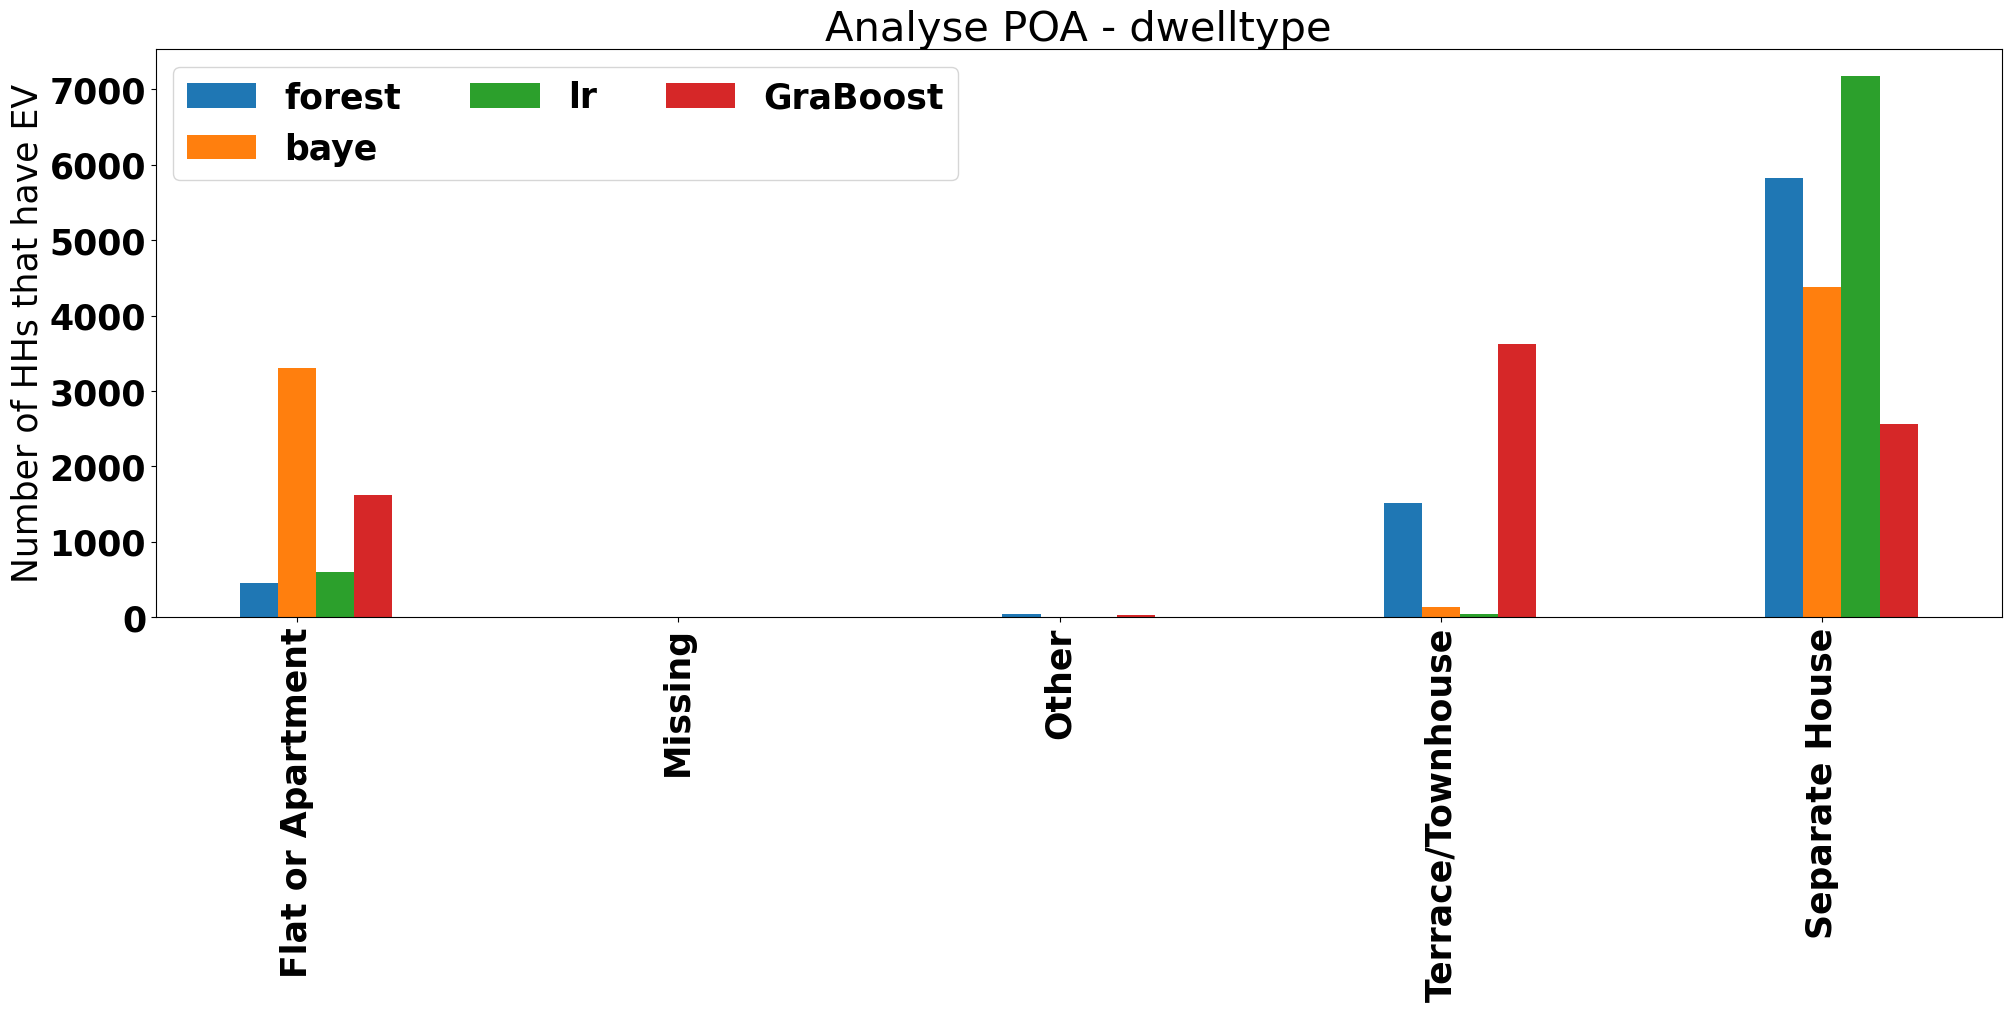

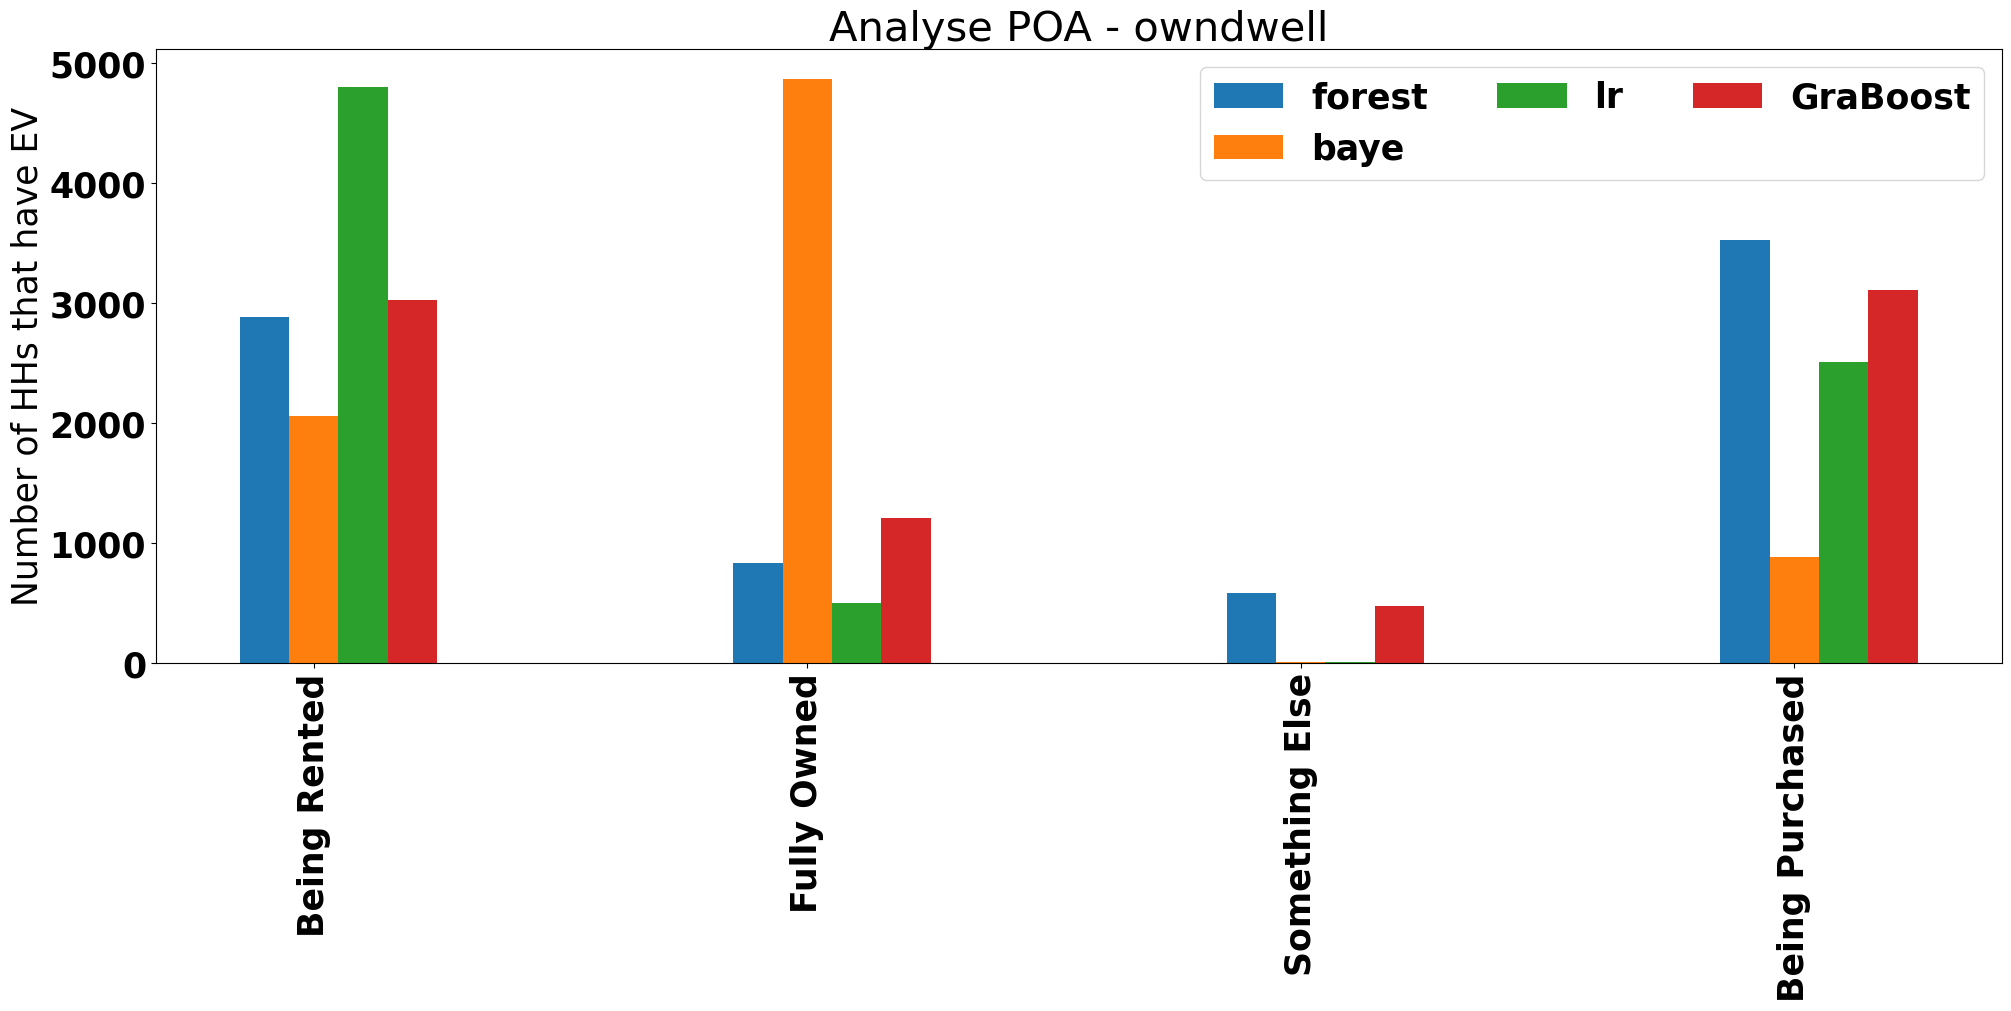

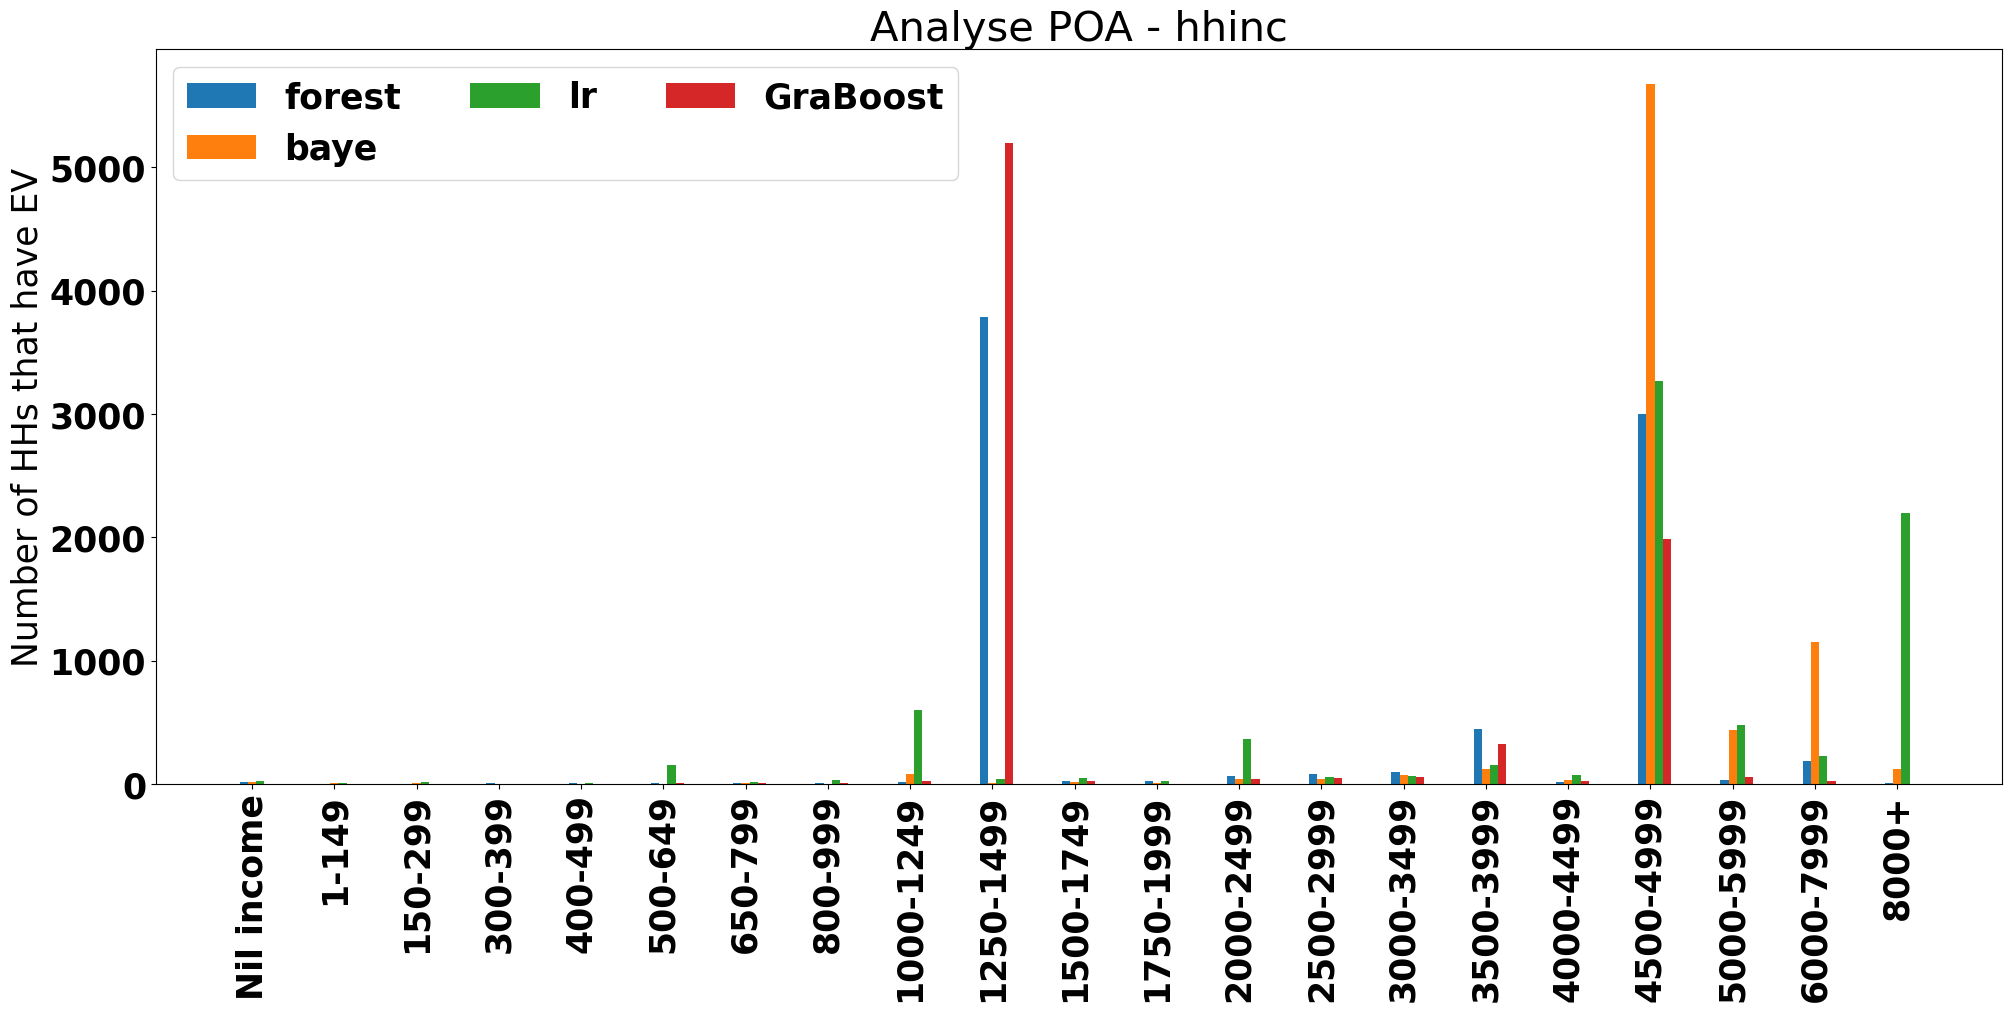

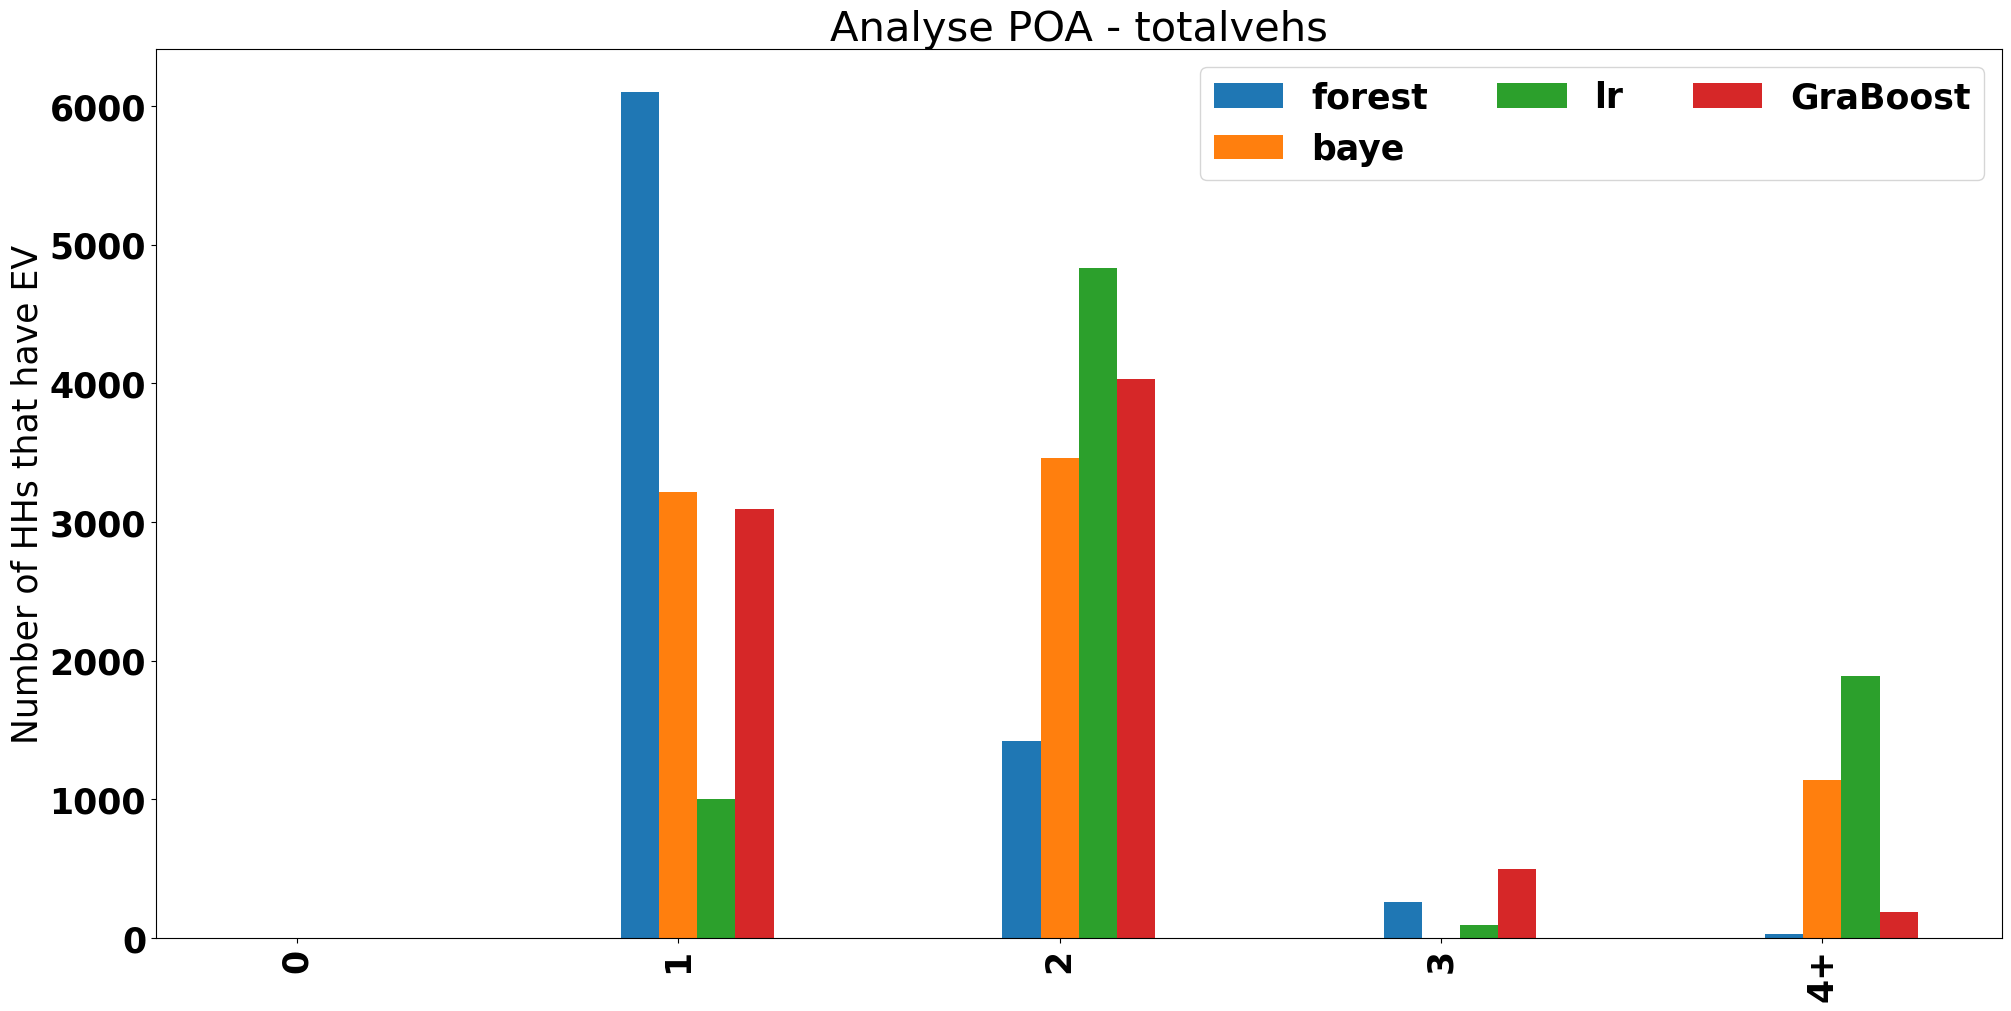

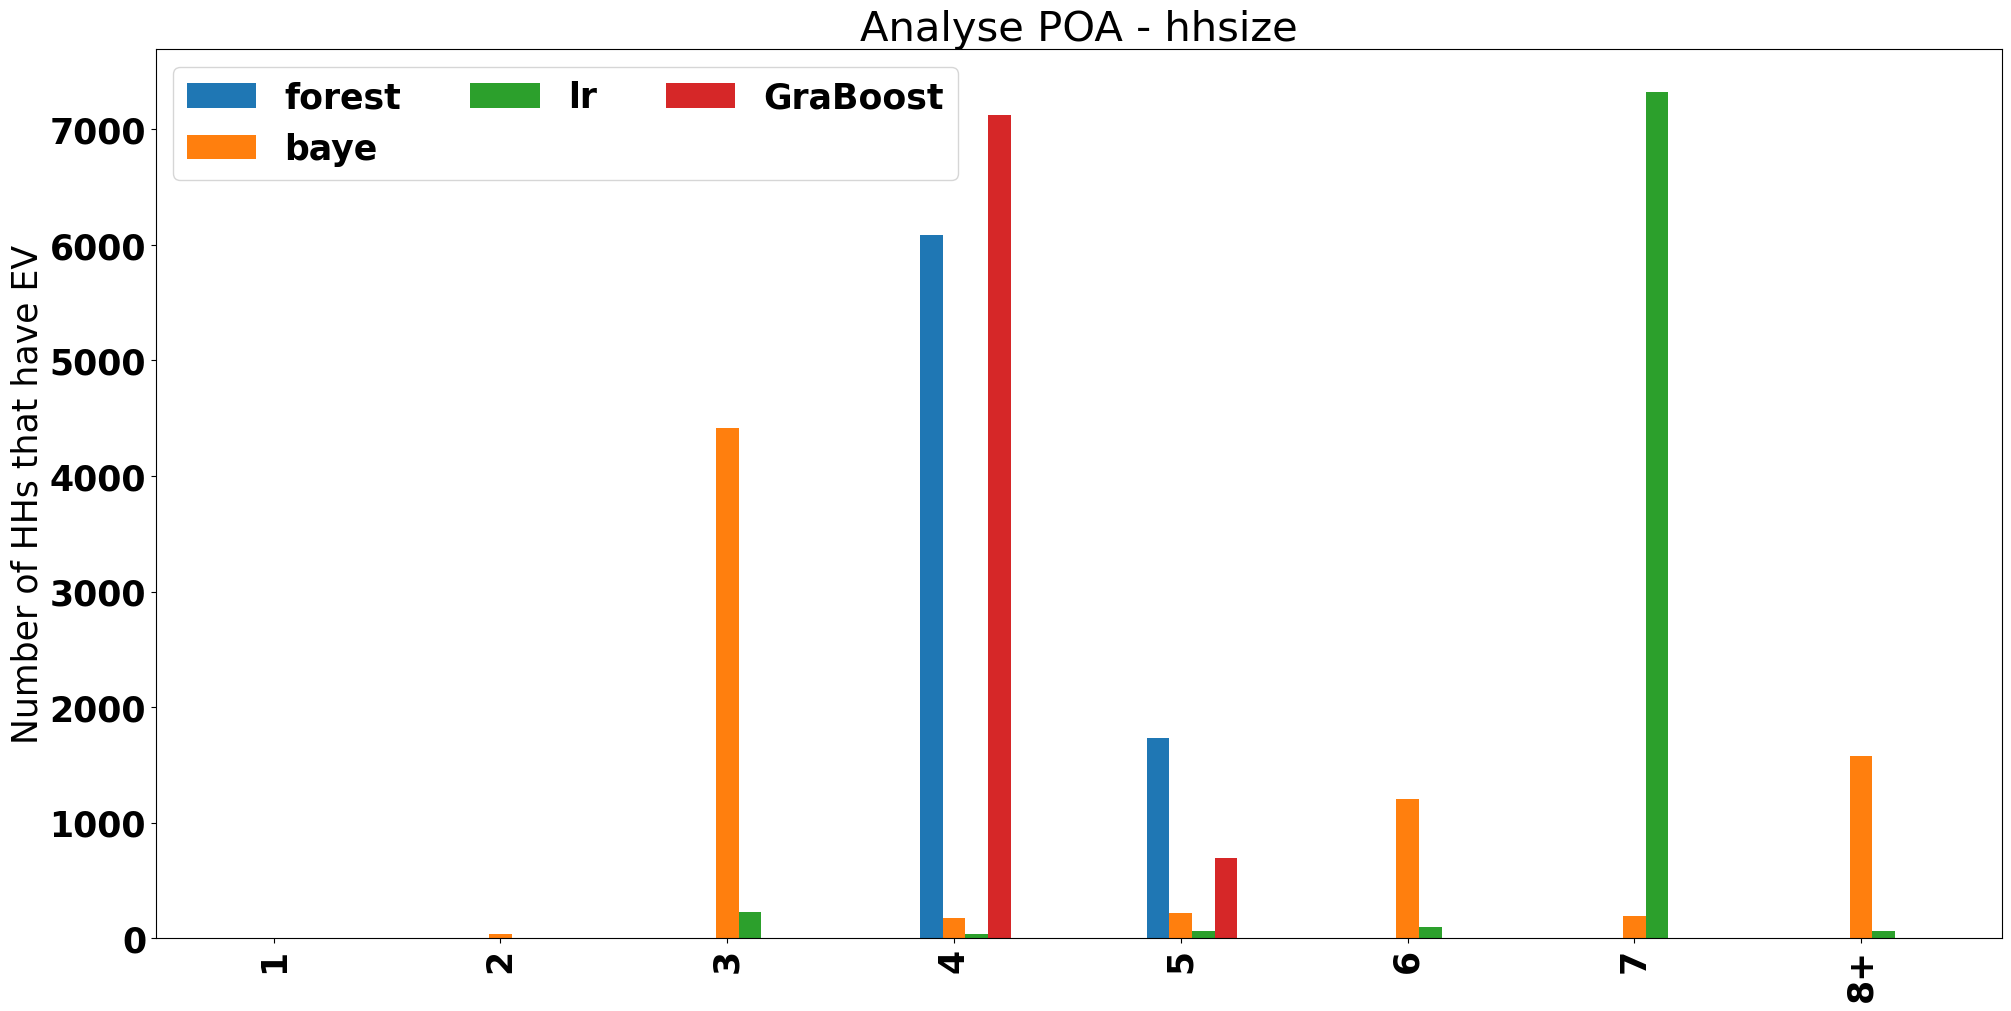

In [27]:
for col in ori_df.columns:
    to_plot_mul_bars(dict_counts_methods_atts, ls_methods, col)

### Get threshold and see across area

     POA_CODE21                               POA_NAME21 AUS_CODE21  \
0          0800                                     0800        AUS   
1          0810                                     0810        AUS   
2          0812                                     0812        AUS   
3          0820                                     0820        AUS   
4          0822                                     0822        AUS   
...         ...                                      ...        ...   
2639       7469                                     7469        AUS   
2640       7470                                     7470        AUS   
2641       9494                 No usual address (Aust.)        AUS   
2642       9797  Migratory - Offshore - Shipping (Aust.)        AUS   
2643       ZZZZ                        Outside Australia        ZZZ   

             AUS_NAME21   AREASQKM21  \
0             Australia       3.1731   
1             Australia      24.4283   
2             Australia    

<Axes: >

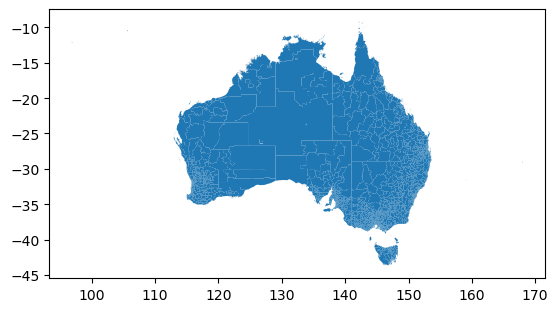

In [122]:
gdf_poa = gpd.read_file("data/POA_2021_AUST_GDA2020_SHP.zip")
print(gdf_poa)
gdf_poa.plot()

In [123]:
dict_thres

{'POA3000': {'EV_pred_forest': 0.0176744557549141,
  'EV_pred_baye': 0.0149313970684357,
  'EV_pred_lr': 0.0657462018701023,
  'EV_pred_GraBoost': 0.0116210867376025,
  'EV_pred_Pearsons': 0.4452564329349267},
 'POA3002': {'EV_pred_forest': 0.0202740118995977,
  'EV_pred_baye': 0.014780983791845,
  'EV_pred_lr': 0.0568109311406843,
  'EV_pred_GraBoost': 0.0137273919047346,
  'EV_pred_Pearsons': 0.4087658072974631},
 'POA3003': {'EV_pred_forest': 0.0224945931636275,
  'EV_pred_baye': 0.0164021878613859,
  'EV_pred_lr': 0.0739762652114486,
  'EV_pred_GraBoost': 0.0137273919047346,
  'EV_pred_Pearsons': 0.4802982333217107},
 'POA3004': {'EV_pred_forest': 0.0157190774511683,
  'EV_pred_baye': 0.0147333770840876,
  'EV_pred_lr': 0.0568109311406843,
  'EV_pred_GraBoost': 0.0113355570767535,
  'EV_pred_Pearsons': 0.3959967488286938},
 'POA3006': {'EV_pred_forest': 0.0188376144534387,
  'EV_pred_baye': 0.0163891666914628,
  'EV_pred_lr': 0.0710563143705826,
  'EV_pred_GraBoost': 0.013727391904

In [128]:
data_df_build = {
    "POA_NAME21": []
}

for zone in dict_thres:
    name = zone[3:]
    data_df_build["POA_NAME21"].append(name)
    for method in dict_thres[zone]:
        me_n = method.split("_")[-1]
        if me_n not in data_df_build:
            data_df_build[me_n] = [dict_thres[zone][method]]
        else:
            data_df_build[me_n].append(dict_thres[zone][method])

df_thres_diff = pd.DataFrame(data_df_build)
df_thres_diff

,POA_NAME21,forest,baye,lr,GraBoost,Pearsons
0,3000,0.017674,0.014931,0.065746,0.011621,0.445256
1,3002,0.020274,0.014781,0.056811,0.013727,0.408766
2,3003,0.022495,0.016402,0.073976,0.013727,0.480298
3,3004,0.015719,0.014733,0.056811,0.011336,0.395997
4,3006,0.018838,0.016389,0.071056,0.013727,0.483627
...,...,...,...,...,...,...
687,3990,0.000888,-0.008893,-0.037849,0.001441,-0.363464
688,3991,0.000830,-0.010218,-0.045338,0.001441,-0.449707
689,3992,0.000828,-0.009340,-0.061355,0.001441,-0.464207
690,3995,0.028547,0.017730,0.282661,0.014338,0.555659


<Axes: >

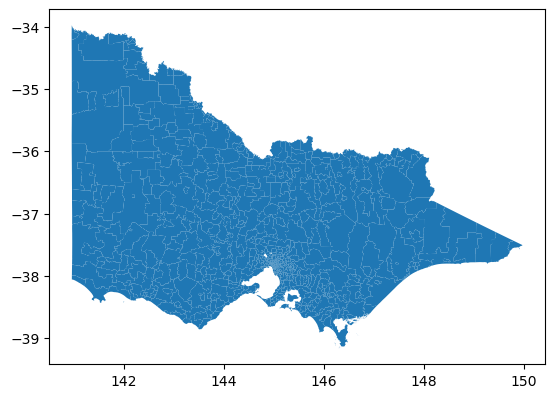

In [130]:
vic_gpd = gdf_poa.merge(df_thres_diff, on="POA_NAME21")
vic_gpd.plot()

<Axes: >

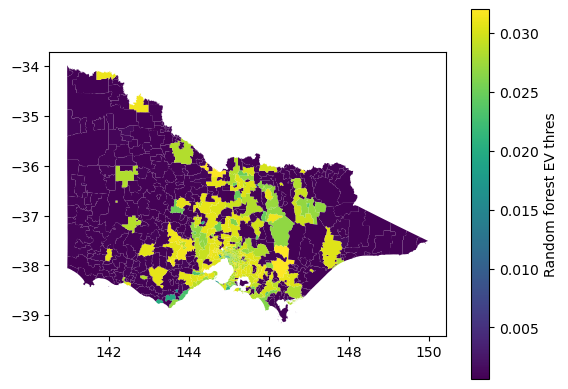

In [138]:
vic_gpd.plot(column="forest", legend=True, legend_kwds={"label": "Random forest EV thres"})

<Axes: >

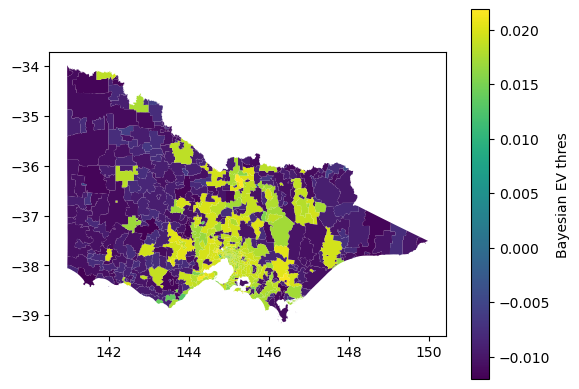

In [134]:
vic_gpd.plot(column="baye", legend=True, legend_kwds={"label": "Bayesian EV thres"})

<Axes: >

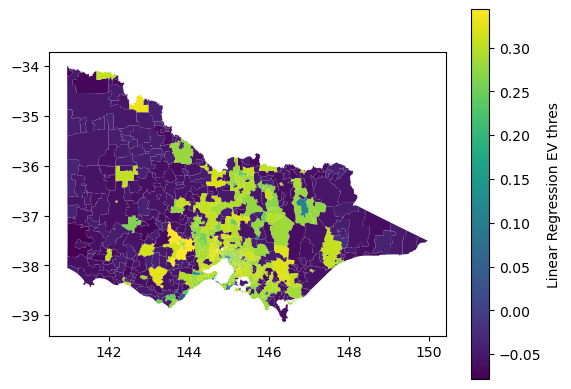

In [135]:
vic_gpd.plot(column="lr", legend=True, legend_kwds={"label": "Linear Regression EV thres"})

<Axes: >

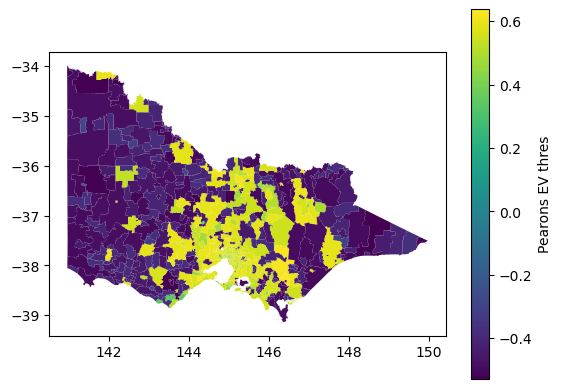

In [136]:
vic_gpd.plot(column="Pearsons", legend=True, legend_kwds={"label": "Pearons EV thres"})

<Axes: >

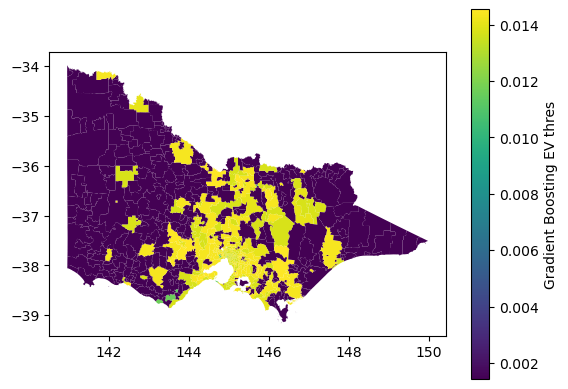

In [137]:
vic_gpd.plot(column="GraBoost", legend=True, legend_kwds={"label": "Gradient Boosting EV thres"})